In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn
import scipy
import mne
import os
import pandas as pd
import numpy as np
import mne
import scipy
import pickle
import multiprocessing
from itertools import repeat

### idea here: rewrite SW detection code for STN activity

In [6]:
# file to read: 
PATH = "C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\BIDS Berlin\\sub-002\\ses-20200130\\ieeg\\sub-002_ses-20200130_task-restMEDON20200130T111458_run-0_ieeg.vhdr"
PATH_OUT = "C:\\Users\\ICN_admin\\Charité - Universitätsmedizin Berlin\\Interventional Cognitive Neuromodulation - Data\\BIDS Berlin\\derivative_SW\\"

In [4]:
raw = mne.io.read_raw_brainvision(PATH)

Extracting parameters from C:\Users\ICN_admin\Charité - Universitätsmedizin Berlin\Interventional Cognitive Neuromodulation - Data\BIDS Berlin\sub-002\ses-20200130\ieeg\sub-002_ses-20200130_task-restMEDON20200130T111458_run-0_ieeg.vhdr...
Setting channel info structure...


In [27]:
class NoValidTroughException(Exception):
    pass

def get_peaks_around(trough_ind, arr_ind_peaks, filtered_dat):

        # find all peaks to the right (then left) side, then take the closest one to the trough
        ind_greater = np.where(arr_ind_peaks>trough_ind)[0]
        if ind_greater.shape[0] == 0:
            raise NoValidTroughException("No valid trough")
        val_ind_greater = arr_ind_peaks[ind_greater]
        peak_right_idx = arr_ind_peaks[ind_greater[np.argsort(val_ind_greater)[0]]]

        ind_smaller = np.where(arr_ind_peaks<trough_ind)[0]
        if ind_smaller.shape[0] == 0:
            raise NoValidTroughException("No valid trough")

        val_ind_smaller = arr_ind_peaks[ind_smaller]
        peak_left_idx = arr_ind_peaks[ind_smaller[np.argsort(val_ind_smaller)[-1]]]

        return peak_left_idx, peak_right_idx, filtered_dat[peak_left_idx], filtered_dat[peak_right_idx]

In [39]:
def analyze_waveform(dat, subject_id, DETECT_PEAKS, sample_rate, line_noise, \
                     ch, PATH_OUT, bp_low_cutoff=5, bp_high_cutoff=90, plot_=False):
    
    """
    saves dict with pd table of detected sharp waves and sw characetristics 
    
    dat: np array of time vector for used channel
    subject_id: str for saving result 
    DETECT_PEAKS: bool if true PEAKS are analyzed, if false: troughs
    sample_rate: int
    line_noise: int
    ch: str used channel
    PATH_OUT: path for saving
    bp_low_cutoff: data is bandpass filtered before preprocessing
    bp_high_cutoff: data is bandpass filtered before preprocessing
    plot_: plot detected SW 
    
    """

    if DETECT_PEAKS is True:
        peak_dist=5; trough_dist=1;  # ms distance between detected troughs / peaks 
        raw_dat = -dat  # Negative for Peaks
    else:
        peak_dist=1; trough_dist=5;
        raw_dat = dat

    # first notch filter data
    dat_notch_filtered = mne.filter.notch_filter(x=raw_dat, Fs=sample_rate, trans_bandwidth=7,
        freqs=np.arange(line_noise, 4*line_noise, line_noise),
        fir_design='firwin', verbose=False, notch_widths=1,filter_length=raw_dat.shape[0]-1)
    
    filter_ = mne.filter.create_filter(None, sample_rate, l_freq=bp_low_cutoff, h_freq=bp_high_cutoff,
                                fir_design='firwin', l_trans_bandwidth=5,
                                h_trans_bandwidth=5, filter_length='1000ms')
    

    filtered_dat = scipy.signal.convolve(dat_notch_filtered, filter_, mode='same')

    peaks = scipy.signal.find_peaks(filtered_dat, distance=peak_dist)[0]
    troughs = scipy.signal.find_peaks(-filtered_dat, distance=trough_dist)[0]

    if plot_ is True:
        plt.figure(figsize=(15,5))
        plt.plot(peaks, filtered_dat[peaks], "xr");
        plt.plot(troughs, filtered_dat[troughs], "ob");
        plt.plot(filtered_dat, color='black'); plt.legend(['peaks', 'trough'])
        plt.show()

    df  = pd.DataFrame()
    sharp_wave = {}
    for trough_idx in troughs:
        try:
            peak_idx_left, peak_idx_right, peak_left, peak_right = get_peaks_around(trough_idx,
                                                                                    peaks, filtered_dat)
        except NoValidTroughException as e:
            # in this case there is no adjacent two peaks around this trough
            print(str(e))
            continue

        # interval
        if df.shape[0]>0:
            interval_ = (trough_idx - sharp_wave["trough_idx"]) * (1000/sample_rate)
        else:
            # set first interval to zero
            interval_ = 0

        # sharpness
        if (trough_idx - int(5*(1000/sample_rate)) <= 0) or \
            (trough_idx + int(5*(1000/sample_rate)) >= filtered_dat.shape[0]):
            continue
        # convert 5 ms to sample rate
        sharpness = ((filtered_dat[trough_idx] - filtered_dat[trough_idx-int(5*(1000/sample_rate))]) +
                     (filtered_dat[trough_idx] - filtered_dat[trough_idx+int(5*(1000/sample_rate))])) / 2

        # rise_steepness, first der. from trough to peak
        # here  + 1 due to python syntax, s.t. the last element is included
        rise_steepness = np.max(np.diff(filtered_dat[peak_idx_left : trough_idx+1]))

        # decay_steepness
        decay_steepness = np.max(np.diff(filtered_dat[trough_idx : peak_idx_right+1]))

        sharp_wave  = {
            "peak_left" : peak_left,
            "peak_right" : peak_right,
            "peak_idx_left" : peak_idx_left,
            "peak_idx_right" : peak_idx_right,
            "trough" : filtered_dat[trough_idx], # mV
            "trough_idx" : trough_idx,
            "width" : peak_idx_right - peak_idx_left, # ms
            "prominence": np.abs((peak_right + peak_left) / 2 - filtered_dat[trough_idx]), # mV
            "interval" : interval_, # ms
            "decay_time": (peak_idx_left - trough_idx) *(1000/sample_rate),
            "rise_time" : (peak_idx_right - trough_idx) *(1000/sample_rate),
            "sharpness" : sharpness,
            "rise_steepness" : rise_steepness,
            "decay_steepness" : decay_steepness,
            "slope_ratio" : rise_steepness - decay_steepness
        }

        df = df.append(sharp_wave, ignore_index=True)

    df.to_pickle(PATH_OUT + "sub_"+subject_id+"_ch_"+ch+".p")

In [40]:
raw.ch_names[19]

'ECOG_AT_SM_L_1'

In [30]:
raw.get_data().shape

(27, 1232738)

In [45]:
subject_id = "002"
ch = raw.ch_names[19]
dat = raw.get_data()[19,:]

No data specified. Sanity checks related to the length of the signal relative to the filter order will be skipped.
Setting up band-pass filter from 5 - 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 5.00
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 2.50 Hz)
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 92.50 Hz)
- Filter length: 4097 samples (1.000 sec)



C:\Users\ICN_admin\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


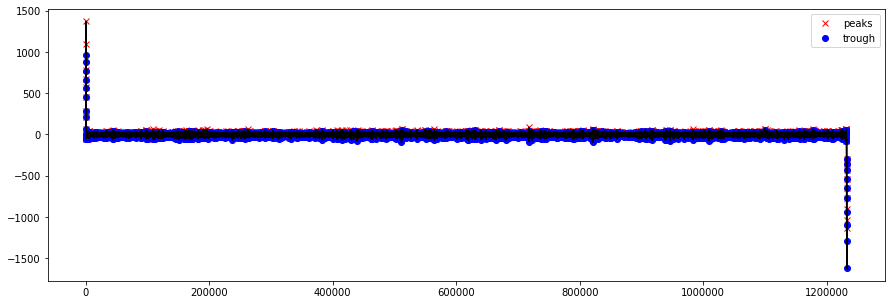

No valid trough


In [46]:
#Remark: Find sample rate in channel.tsv file: 
# e.g. sub-002_ses-20200130_task-restMEDONAVGREF20200130T112142_run-1_channels

analyze_waveform(dat, subject_id=subject_id, DETECT_PEAKS=False, sample_rate=4096, line_noise=50, \
                     ch=ch, PATH_OUT=PATH_OUT, bp_low_cutoff=5, bp_high_cutoff=90, plot_=True)

In [43]:
df = pd.read_pickle(PATH_OUT + "sub_"+subject_id+"_ch_"+ch+".p")

In [44]:
df

,decay_steepness,decay_time,interval,peak_idx_left,peak_idx_right,peak_left,peak_right,prominence,rise_steepness,rise_time,sharpness,slope_ratio,trough,trough_idx,width
0,10.514638,-5.859375,0.000000,21.0,64.0,1368.959044,1090.469938,267.547903,-1.823353,4.638672,-1.141260,-12.337991,962.166588,45.0,43.0
1,4.138661,-6.591797,11.230469,64.0,107.0,1090.469938,923.240906,126.168071,-0.477547,3.906250,-0.500685,-4.616208,880.687351,91.0,43.0
2,2.440880,-7.080078,10.986328,107.0,151.0,923.240906,785.444566,92.119324,-0.346909,3.662109,-0.324108,-2.787788,762.223412,136.0,44.0
3,1.493870,-7.324219,10.986328,151.0,194.0,785.444566,677.371859,66.751248,-0.090384,3.173828,-0.213345,-1.584254,664.656965,181.0,43.0
4,0.837886,-7.812500,10.986328,194.0,237.0,677.371859,572.298936,58.345733,-0.193948,2.685547,-0.156663,-1.031834,566.489665,226.0,43.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15468,0.720370,-8.544922,10.498047,1232465.0,1232510.0,-537.113453,-644.449920,58.144012,-0.020317,2.441406,-0.155721,-0.740687,-648.925699,1232500.0,45.0
15469,1.383360,-8.056641,10.498047,1232510.0,1232554.0,-644.449920,-763.929564,70.091907,-0.274475,2.685547,-0.225582,-1.657835,-774.281649,1232543.0,44.0
15470,3.186355,-8.056641,10.742188,1232554.0,1232601.0,-763.929564,-907.507066,102.726754,-0.027142,3.417969,-0.365210,-3.213497,-938.445069,1232587.0,47.0
15471,5.367009,-7.080078,10.498047,1232601.0,1232646.0,-907.507066,-1034.468667,120.650318,-0.118744,3.906250,-0.537469,-5.485753,-1091.638184,1232630.0,45.0


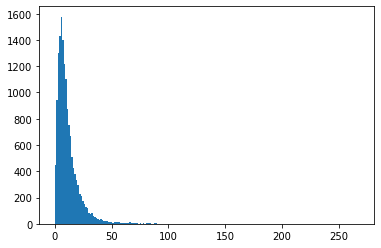

In [52]:
plt.hist(df["prominence"], bins=200)
plt.show()

### now check STN activity wrt cortical sharp waves 

In [75]:
raw.ch_names[10]

'LFP_BS_STN_L_2'

In [76]:
dat_STN_R1 = raw.get_data()[1,:]

In [77]:
dat_STN_R1.shape

(1232738,)

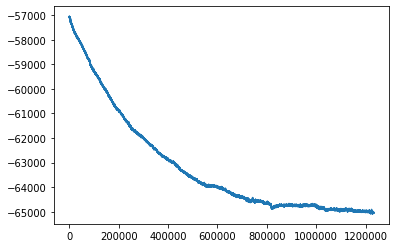

In [78]:
plt.plot(dat_STN_R1) #### mhhh, strange trace

In [80]:
arr_ = []
epoch_length = 4096
for t in df["trough_idx"].astype(int):
    if t-epoch_length < 0 or t + epoch_length > dat_STN_R1.shape[0]:
        continue
    arr_.append(dat_STN_R1[t-epoch_length:t+epoch_length])

In [81]:
arr_ = np.array(arr_)

In [82]:
arr_.shape

(15366, 8192)

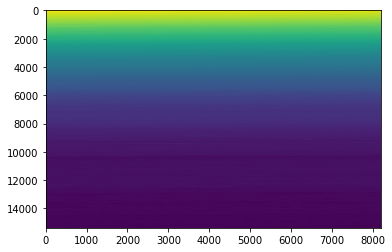

In [83]:
plt.imshow(arr_, aspect='auto')

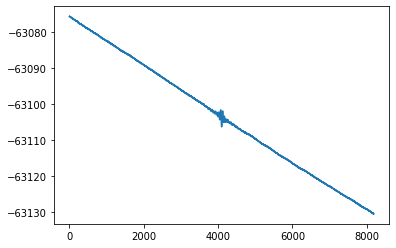

In [66]:
plt.plot(np.mean(arr_, axis=0))

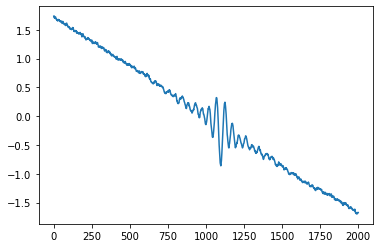

In [85]:
plt.plot(scipy.stats.zscore(np.mean(arr_, axis=0)[3000:5000]))